In [7]:
import yahoo_fin
from yahoo_fin.stock_info import get_data
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from scipy.stats import norm
import datetime
%matplotlib inline

In [9]:
start = '01/01/2018'
#end = '09/22/2022'
today = date.today()
end = today.strftime("%m/%d/%y")

In [10]:
def stock_data(x, start, end):
    df = get_data(x, start_date = start, end_date = end, index_as_date = True, interval = '1d')
    df.reset_index(inplace = True)
    df = df.rename(columns = {df.columns[0]:'date'})
    df = df.drop(columns = {'ticker'})
    return df

In [11]:
 def visualise_data(df):
    # Plot the data
    plt.figure(figsize = (14, 7))
    plt.plot(df['date'], df['close'], label = 'Close Price')
    plt.title('Stock Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def SMA(df, n):
    return df.rolling(n).mean()

In [186]:
def comprehensive_data(stock, period, start, end):
    # Get stock data
    df = stock_data(stock, start, end)
    
#     # Calculate VWMA
#     temp = df['close'] * df['volume']
#     VWMA = [None] * (period - 1)
#     accumulator = sum(temp[:period])
    
#     VWMA.append(accumulator / sum(df['volume'][:period]))
    
#     for i in range(1, len(temp) - period + 1):
#         accumulator = accumulator - temp[i - 1] + temp[i + period - 1]
#         VWMA.append(accumulator / sum(df['volume'][i:i + period]))
    
#     df['VWMA'] = VWMA
#     df = df.dropna(subset = ['VWMA'])

    # Calculate SMA
    temp = SMA(df['close'], period)
    df['SMA'] = temp

    # Calculate change from yesterday
    
    
    # Calculate change and % change from previous day
    # Change and % change from previous day
    df['temp'] = df['close'].shift(periods = 1) 
    df['change'] = df['close'] - df['temp']

    # So no NaNs in the VWMA or SMA column
    # df = df.dropna(subset = ['temp', 'VWMA'])
    df = df.dropna(subset = ['temp', 'SMA'])
    
    # Calculate deviation from SMA
    df['deviation'] = df['close'] - df['SMA']
    
    df = df.drop(columns = ['adjclose', 'high', 'low'])
    return df

In [187]:
comprehensive_data('AUDUSD=X', 25, start, today)

,date,open,close,volume,SMA,temp,change,deviation
24,2018-02-02,0.804117,0.804052,0.0,0.794850,0.806127,-0.002074,0.009203
25,2018-02-05,0.790670,0.790639,0.0,0.795267,0.804052,-0.013414,-0.004628
26,2018-02-06,0.787637,0.787464,0.0,0.795561,0.790639,-0.003175,-0.008097
27,2018-02-07,0.789278,0.789391,0.0,0.795801,0.787464,0.001927,-0.006410
28,2018-02-08,0.781739,0.781739,0.0,0.795757,0.789391,-0.007652,-0.014018
...,...,...,...,...,...,...,...,...
1741,2024-09-02,0.678730,0.678730,0.0,0.665286,0.676800,0.001930,0.013444
1742,2024-09-03,0.671400,0.671400,0.0,0.665976,0.678730,-0.007330,0.005424
1743,2024-09-04,0.671619,0.671619,0.0,0.666653,0.671400,0.000219,0.004966
1744,2024-09-05,0.674050,0.674050,0.0,0.667636,0.671619,0.002431,0.006415


In [14]:
# Get df for a stock
# Need to run before next part
data = comprehensive_data('AUDUSD=X', 100, start, today)
data = data.drop(columns = ['volume'])

In [15]:
def distribution(df, threshold):
    # Calculate distribution of devia_tion from MA / % cha_nge
    # Replace devia_tion <-> cha_nge
    mean = np.mean(df['deviation'])
    std = np.std(df['deviation'])
     
    # Calculate the z-score threshold
    # This is for 90% CI
#     z_threshold = 1.645
    # This is for 95% CI
    z_threshold = 1.96
    # This is for 99% CI
#     z_threshold = 2.576
    
    
    # Calculate the actual value thresholds
    lower_threshold = mean - z_threshold * std
    upper_threshold = mean + z_threshold * std
    
    # Identify outliers
    outliers = df[(df['deviation'] < lower_threshold) | (df['deviation'] > upper_threshold)]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(df['deviation'], bins = 100, density = True, alpha = 0.6, color = 	"#4DBEEE")

    # Plot the normal distribution curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth = 1)
    title = "Distribution of Daily deviation"
    plt.title(title)

    plt.show()
    
    return outliers

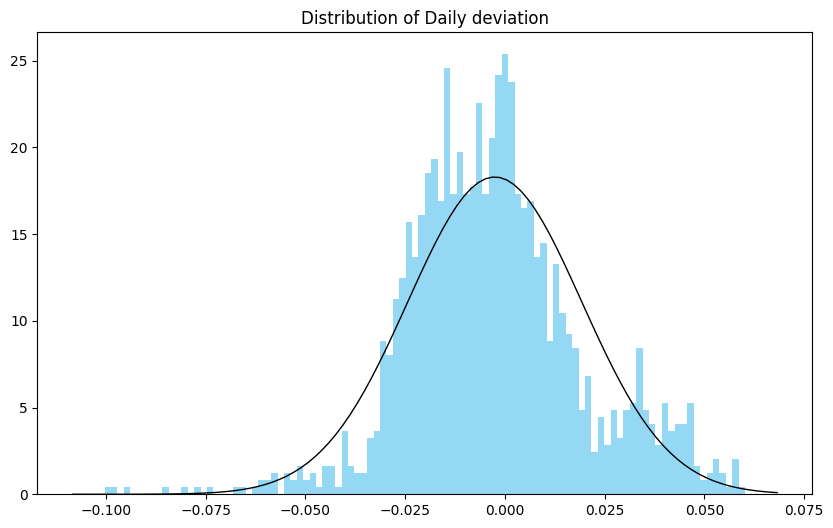

,date,open,close,SMA,deviation
574,2020-03-13,0.628210,0.627412,0.679126,-0.051715
575,2020-03-16,0.617871,0.617768,0.678480,-0.060712
576,2020-03-17,0.610450,0.609942,0.677740,-0.067798
577,2020-03-18,0.598830,0.599220,0.676876,-0.077656
578,2020-03-19,0.579950,0.580980,0.675788,-0.094808
...,...,...,...,...,...
1323,2023-01-26,0.710820,0.710820,0.665156,0.045664
1324,2023-01-27,0.711390,0.711390,0.665504,0.045886
1325,2023-01-30,0.710798,0.710798,0.665765,0.045033
1328,2023-02-02,0.714500,0.714500,0.666630,0.047870


In [16]:
distribution(data, 1)

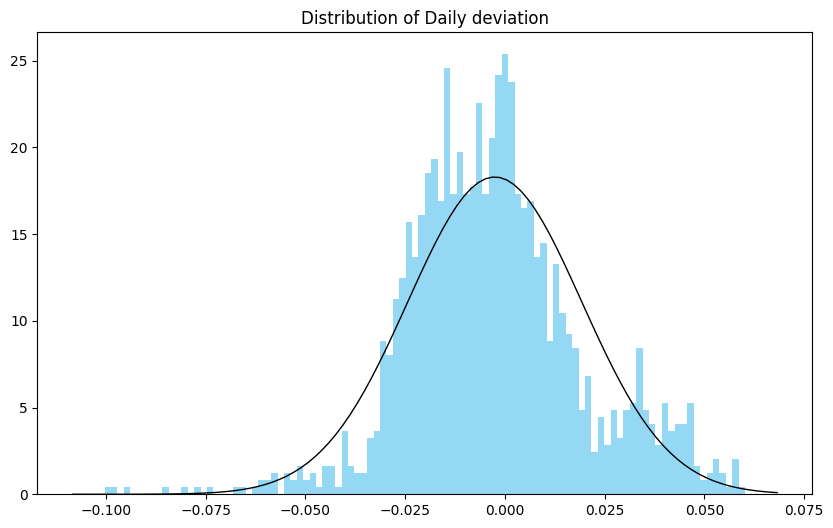

In [17]:
outlier_dates = distribution(data, 1)['date']

In [18]:
for date in outlier_dates:
    print(date)

2020-03-13 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-06-02 00:00:00
2020-06-03 00:00:00
2020-06-04 00:00:00
2020-06-07 00:00:00
2020-06-08 00:00:00
2020-06-09 00:00:00
2020-06-10 00:00:00
2020-06-15 00:00:00
2020-06-16 00:00:00
2020-06-22 00:00:00
2020-06-23 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00


In [188]:
def trade_after_outlier(outlier_dates, stock, period, days_after = 30):
    trade_summary = []
    previous_date = outlier_dates.min() - datetime.timedelta(days = 21)
    filtered_dates = []
    
    for date in outlier_dates:
        if (date - previous_date).days > 10:
            filtered_dates.append(date)
            previous_date = date
            
    # Fetch stock data
    data = comprehensive_data(stock, period, start, today)
    
    for date in filtered_dates:
        start_date = date - datetime.timedelta(days = 0)
        end_date = date + datetime.timedelta(days = days_after)
        
        # Create temporary df with the date ranges
        temp = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

        # Plot cumulative returns
        temp['temp'] = temp['change'].shift(-1)
        temp['cum_returns'] = temp['temp'].cumsum() 
        temp = temp.drop(columns = ['temp'])
        temp = temp.dropna()

        # Plot the data
        plt.figure(figsize = (10, 6))
        # Plot close against SMA
        # plt.plot(data[(data['date'] >= start_date) & (data['date'] <= end_date)]['date'], data[(data['date'] >= start_date) & (data['date'] <= end_date)]['close'], label = 'Close Price')
        # plt.plot(data[(data['date'] >= start_date) & (data['date'] <= end_date)]['date'], data[(data['date'] >= start_date) & (data['date'] <= end_date)]['SMA'], label = 'SMA')

        # Plot deviation from SMA and cum_returns
        plt.plot(temp['date'], temp['deviation'], label = 'Deviation from SMA')
        plt.plot(temp['date'], temp['cum_returns'], label = 'cum_returns')

        plt.title(f'Security Movement after shock {date}')
        plt.xticks(rotation = 45)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Finding the cumulative return for the period
        trade_entry = temp['date'].min().strftime('%d-%m-%Y')
        trade_exit = temp['date'].max().strftime('%d-%m-%Y')
        cum_return = temp.loc[temp['cum_returns'].last_valid_index(), 'cum_returns']

        trade_summary.append([trade_entry, trade_exit, cum_return])
        break
    return temp
    


C:\Users\Linus\AppData\Local\Temp\ipykernel_4680\2790657205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['temp'] = temp['change'].shift(-1)
C:\Users\Linus\AppData\Local\Temp\ipykernel_4680\2790657205.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['cum_returns'] = temp['temp'].cumsum()


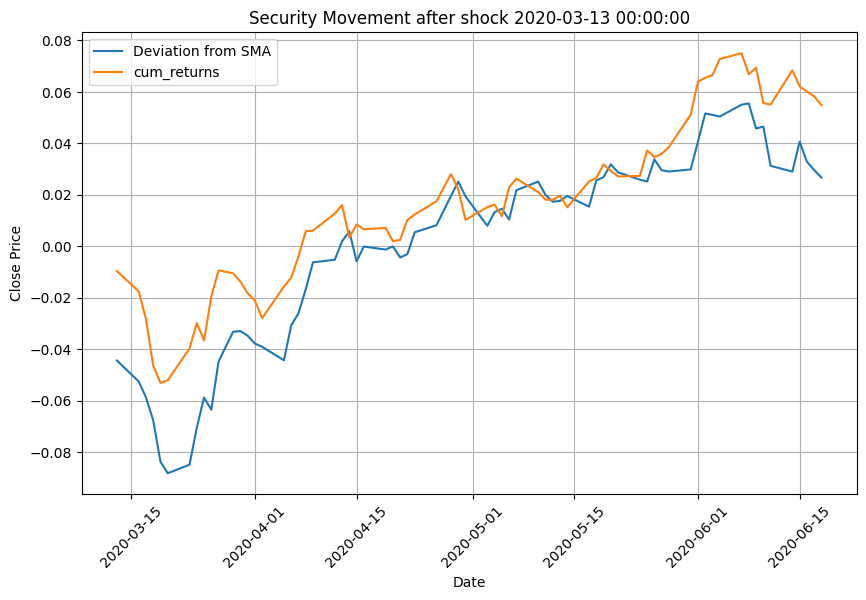

,date,open,close,volume,SMA,change,deviation,cum_returns
574,2020-03-13,0.628210,0.627412,0.0,0.671811,-0.020528,-0.044399,-0.009643
575,2020-03-16,0.617871,0.617768,0.0,0.670278,-0.009643,-0.052510,-0.017470
576,2020-03-17,0.610450,0.609942,0.0,0.668602,-0.007826,-0.058660,-0.028192
577,2020-03-18,0.598830,0.599220,0.0,0.666866,-0.010722,-0.067646,-0.046432
578,2020-03-19,0.579950,0.580980,0.0,0.664738,-0.018240,-0.083758,-0.053121
...,...,...,...,...,...,...,...,...
640,2020-06-14,0.682920,0.682501,0.0,0.653472,-0.000587,0.029029,0.068409
641,2020-06-15,0.696140,0.695820,0.0,0.655153,0.013319,0.040667,0.062120
642,2020-06-16,0.689470,0.689532,0.0,0.656639,-0.006289,0.032892,0.060159
643,2020-06-17,0.687711,0.687570,0.0,0.657920,-0.001961,0.029650,0.058309


In [189]:
trade_after_outlier(outlier_dates, 'AUDUSD=X', 50, days_after = 100)

In [ ]:
period = 10

def shock(stock, severity, start, end, period):
    data = stock_data(stock, start, end)
    vwma = VWMA(stock, period)